In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16988386880743400751
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5857542144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10508840544376660624
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
]


In [8]:
# load the input and output images -> done
# plot the images to check if they're correct -> done
# define placeholders for them
# define the convolution graph
# divide the dataset into batches
# write the training code and save the model after training
# use the saved model for testing
# plot the image and respective predicted class along with probability


# experiment
# image manipulation and see the accuracy
# layer manipulation and see the accuracy
# different accuracy metrics

# increase image size
# imcrease layers
# use predefined layers
# use dropout


# Importing data

In [9]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [10]:
# importing our training and testing data
xtrain = np.load('xtrain.npy')
ytrain = np.load('ytrain.npy')

xtest = np.load('xtest.npy')
ytest = np.load('ytest.npy')

_,height,width = xtrain.shape
channels = 1
classes=2
xtrain,ytrain = unison_shuffled_copies(xtrain,ytrain)
xtrain = np.reshape(xtrain,(-1,height,width,channels))
xtest = np.reshape(xtest,(-1,height,width,channels))
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    ytrain = sess.run(tf.one_hot(ytrain,depth=classes))
    ytest = sess.run(tf.one_hot(ytest,depth=classes))
# getting the label class map
with open('lbl_map.txt','rb') as file:
    lbl_map = pickle.load(file)

In [11]:
print("Toral Training data : {}".format(xtrain.shape[0]))
print("Shape of Training data : {}".format(xtrain.shape))

Toral Training data : 25000
Shape of Training data : (25000, 128, 128, 1)


In [12]:
print("Toral Testing data : {}".format(xtest.shape[0]))
print("Shape of Testing data : {}".format(xtest.shape))

Toral Testing data : 10
Shape of Testing data : (10, 128, 128, 1)


Text(0.5,1,'[1. 0.]')

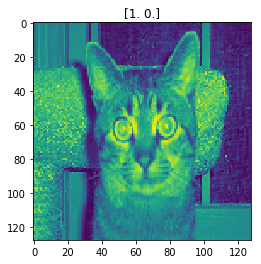

In [13]:
import matplotlib.pyplot as plt
i=402
plt.imshow(xtrain[i].reshape(128,128))
plt.title(ytrain[i])

# Helper Methods

In [14]:
def weights(shape):
    return tf.Variable(tf.random_normal(shape=shape,stddev=0.1))

In [15]:
def biases(shape):
    return tf.Variable(tf.constant(0.1,shape=shape))

In [16]:
def conv2D(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

In [17]:
def maxPool(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [18]:
def convolution_layer(x,shape):
    w = weights(shape)
    b = biases([shape[3]])
    layer = tf.nn.relu(conv2D(x,w)+b)
   
    return layer

In [19]:
def deep_layer(x,size,use_relu=True):
    w = weights([int(x.get_shape()[1]),size])
    b = biases([size])
    layer = tf.matmul(x,w)+b
    if(use_relu):
        layer = tf.nn.relu(layer)
    return layer

# Placeholders 

In [20]:
x_true = tf.placeholder(dtype=tf.float32,shape=(None,128,128,1),name='x_true')

In [21]:
y_true = tf.placeholder(dtype=tf.float32,shape=(None,2),name='y_true')

# Layers

In [22]:
layer1 = convolution_layer(x_true,shape=(5,5,1,16))
layer12 = convolution_layer(layer1,shape=(3,3,16,16))
pooling_layer1 = maxPool(layer12)

In [23]:
layer2 = convolution_layer(pooling_layer1,shape=(5,5,16,32))
layer22 = convolution_layer(layer2,shape=(3,3,32,32))
pooling_layer2 = maxPool(layer22)

In [24]:
layer3 = convolution_layer(pooling_layer2,shape=(5,5,32,64))
pooling_layer3 = maxPool(layer3)

In [25]:
layer4 = convolution_layer(pooling_layer3,shape=(3,3,64,64))
pooling_layer4 = maxPool(layer4)

In [26]:
# flattening layer2 and connecting a deep layer
flatten_layer = tf.reshape(pooling_layer4,shape=(-1,pooling_layer4.get_shape()[1:4].num_elements()))

In [27]:
bottleneck_layer = deep_layer(flatten_layer,1024,True)

In [28]:
output_layer = deep_layer(bottleneck_layer,2,False)

In [29]:
y_pred = tf.nn.softmax(output_layer,name='y_pred')

# Training

In [29]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer,labels=y_true))

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [31]:
equal = tf.cast(tf.equal(tf.argmax(y_true,1),tf.argmax(y_pred,1)),dtype=tf.float32)
accuracy = tf.reduce_mean(equal)

In [32]:
epochs = 200
batch_size = 1000

saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        i=0
        while i < len(xtrain):
            batch_x = np.array(xtrain[i:i+batch_size])
            batch_y = np.array(ytrain[i:i+batch_size])

            sess.run(optimizer,feed_dict={x_true:batch_x,y_true:batch_y})
            i += batch_size
            
        j = np.random.randint(0,len(xtrain)-batch_size)
        random_sample_x = np.array(xtrain[j:j+batch_size])
        random_sample_y = np.array(ytrain[j:j+batch_size])
        if(epoch%10 == 0):    
            print("Training Loss after {} epoch : {}".format(epoch,sess.run(loss,feed_dict={x_true:random_sample_x,y_true:random_sample_y})))
            print("Training Accuracy after {} epoch : {}\n".format(epoch,sess.run(accuracy,feed_dict={x_true:random_sample_x,y_true:random_sample_y})))
        
    saver.save(sess,'saved_models/catvdog.ckpt')

Training Loss after 0 epoch : 42.871795654296875
Training Accuracy after 0 epoch : 0.5120000243186951

Training Loss after 10 epoch : 1.4092680215835571
Training Accuracy after 10 epoch : 0.7120000123977661

Training Loss after 20 epoch : 0.5430822372436523
Training Accuracy after 20 epoch : 0.8169999718666077

Training Loss after 30 epoch : 0.5215197801589966
Training Accuracy after 30 epoch : 0.8059999942779541

Training Loss after 40 epoch : 0.1645197570323944
Training Accuracy after 40 epoch : 0.9380000233650208

Training Loss after 50 epoch : 0.22873181104660034
Training Accuracy after 50 epoch : 0.9049999713897705

Training Loss after 60 epoch : 0.14145223796367645
Training Accuracy after 60 epoch : 0.9359999895095825

Training Loss after 70 epoch : 0.061657484620809555
Training Accuracy after 70 epoch : 0.972000002861023

Training Loss after 80 epoch : 0.22644054889678955
Training Accuracy after 80 epoch : 0.9229999780654907

Training Loss after 90 epoch : 0.08530054241418839
Tr

# Testing

In [30]:
prediction = tf.cast(tf.argmax(y_pred,1),dtype=tf.float32)

In [32]:
saver = tf.train.Saver()

In [33]:
# testing using the trained model
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver.restore(sess,"saved_models/catvdog.ckpt")
    p = sess.run(prediction,feed_dict={x_true:xtest})

INFO:tensorflow:Restoring parameters from saved_models/catvdog.ckpt


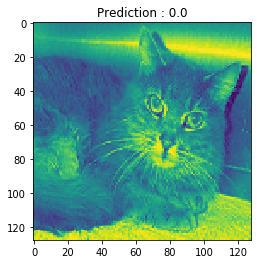

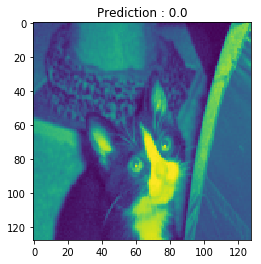

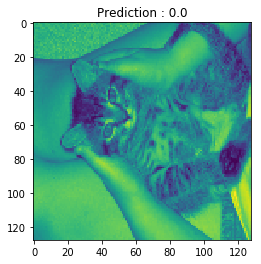

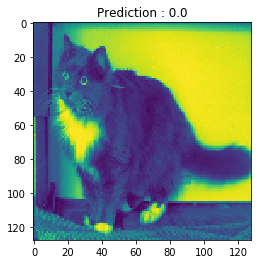

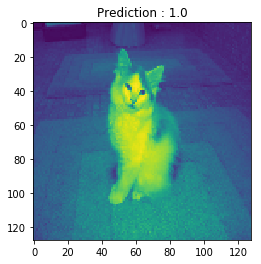

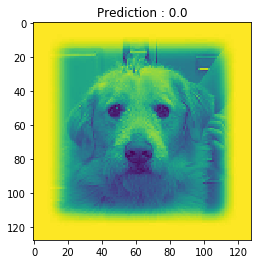

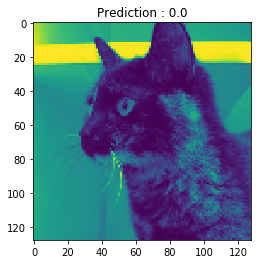

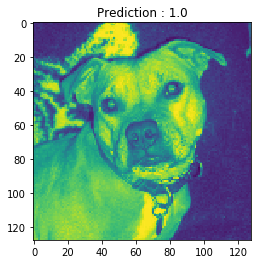

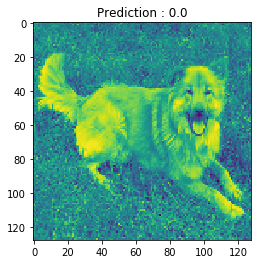

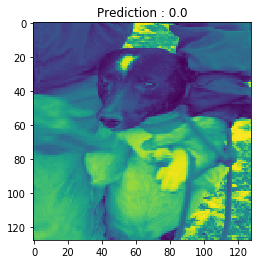

In [34]:
import time
for i in range(len(xtest)):
    plt.figure()
    plt.imshow(xtest[i].reshape(128,128)) 
    plt.title("Prediction : {}".format(p[i]))
    